<a href="https://colab.research.google.com/github/daniel-furman/RandomDS/blob/main/BirdCLEF21_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BirdCLEF 2021 Training Notebook
---

* Convnet audio classification 
* High RAM + GPU environment required
* Efficientnet architectures
* Mixup augs
* Geospatial/temporal representative CV scheme
* Neptune.ai experiment tracking

## Notebook GPU and RAM Info
---

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sun May 30 13:29:44 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


## Notes
---

* To make the training faster, we cached the training set into RAM. The whole training records are already [converted into handy  melspecs images](https://www.kaggle.com/kneroma/kkiller-birdclef-2021). These images are from 7 seconds extracts. Longer records are truncated into 10 random 7 second images.

## Setup
---

In [ ]:
!pip install -q pysndfx SoundFile audiomentations pretrainedmodels efficientnet_pytorch resnest torchaudio

     |████████████████████████████████| 61kB 4.1MB/s 
     |████████████████████████████████| 1.9MB 10.4MB/s 
     |████████████████████████████████| 163kB 26.1MB/s 


In [ ]:
import numpy as np
import librosa as lb
import librosa.display as lbd
import soundfile as sf
from  soundfile import SoundFile
import pandas as pd
from  IPython.display import Audio
from pathlib import Path

import torch
from torch import nn, optim
from  torch.utils.data import Dataset, DataLoader
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T

from efficientnet_pytorch import EfficientNet
import pretrainedmodels
from resnest.torch import resnest50
import resnest.torch as resnest_torch

from matplotlib import pyplot as plt

import os, random, gc
import re, time, json
from  ast import literal_eval

from IPython.display import Audio
from sklearn.metrics import label_ranking_average_precision_score

from tqdm.notebook import tqdm
import joblib

In [ ]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()

## Colab Setup
---

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
! pip install --upgrade --force-reinstall --no-deps  kaggle > /dev/null
! mkdir ~/.kaggle
! cp "/content/drive/MyDrive/Colab Files/scripts/kaggle.json" ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
%%time
#import os
#!mkdir datasets

#!kaggle datasets download -d kneroma/kkiller-birdclef-2021 --force
#!unzip /content//kkiller-birdclef-2021.zip -d datasets

## neptune.ai Setup
---

In [ ]:
!pip install neptune-client
import neptune
#NEPTUNE_API_TOKEN
neptune.init('dryanfurman/BirdCLEF21', api_token=NEPTUNE_API_TOKEN)

## Congifuration
---

In [ ]:
NUM_CLASSES = 397
SR = 32_000

DATA_ROOT = Path("/content/datasets/")

MODEL_ROOT = Path("/content/drive/My Drive/Kaggle/BirdClef2021/models")

TRAIN_IMAGES_ROOT = Path("/content/datasets/audio_images")
TRAIN_LABELS_FILE = Path("/content/datasets/rich_train_metadata.csv")

MEL_PATHS = sorted(Path("/content").glob("datasets/rich_train_metadata.csv"))
TRAIN_LABEL_PATHS = sorted(Path("/content").glob("drive/MyDrive/Kaggle/BirdClef2021/LABEL_IDS.json"))

In [ ]:
PARAMS = {'MAX_READ_SAMPLES' : 10, # Each record will have 10 melspecs at most
          'DURATION' : 7,
          'model_name' : 'resnest50',
          'TRAIN_BATCH_SIZE' : 100,
          'TRAIN_NUM_WORKERS' : 2,
          'VAL_BATCH_SIZE' : 128,
          'VAL_NUM_WORKERS' : 2,
          'epochs' : 12,
          'lr' : 8e-4,
          'lr_anneal' : 1e-5,

          'folds' : [1],
          'fold_type' : 'geotemporal-4fold-56grids',

          'specstriping_aug' : 'disabled',
          'specaugment_prob' : 0,

          'multi_label' : 'enabled',
          'secondary_label_activations' : 0.5,

          'mixup' : 'disabled',
          'mixup_prob' : 0,
          'mixup_alpha' : 0.5,
          'fold_fpath' : '/content/drive/MyDrive/Colab Files/data/birds/gpds_for_blockCV/new_folder_blockcv_equalsplits.csv'
      }

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Device:", DEVICE)

Device: cuda


In [ ]:
def get_df(mel_paths=MEL_PATHS, train_label_paths=TRAIN_LABEL_PATHS):
  df = None
  LABEL_IDS = {}
    
  for file_path in mel_paths:
    temp = pd.read_csv(str(file_path))
    temp["impath"] = temp.apply(lambda row: file_path.parent/"audio_images/{}/{}.npy".format(row.primary_label, row.filename), axis=1) 
    df = temp if df is None else df.append(temp)
    
  df["secondary_labels"] = df["secondary_labels"].apply(literal_eval)
 
  for file_path in train_label_paths:
    with open(str(file_path)) as f:
      LABEL_IDS.update(json.load(f))
  
  df['label_id'] = df['label_id'].astype(object)
  for i in range(0, len(df.primary_label)):
    key_looper = list()
    key_looper.append(df["label_id"][i])
    for keys in df['secondary_labels'][i]:
      try:
        key_looper.append(LABEL_IDS[keys])
      except KeyError:
        print('keyerror unknown species name')
    df["label_id"][i] = key_looper

  return LABEL_IDS, df

In [ ]:
LABEL_IDS, df = get_df()

In [ ]:
new_meta_fold = pd.read_csv(PARAMS['fold_fpath']).fold
new_meta_fold = pd.to_numeric(new_meta_fold, downcast='integer')
df.fold = new_meta_fold

In [ ]:
print(df.shape)
#df.sample(8)

(62874, 21)


In [ ]:
df.fold.value_counts()

5    12933
3    12873
4    12679
2    12307
1    12082
Name: fold, dtype: int64

In [ ]:
df["label_id"]

0                         [0, 5]
1                            [0]
2                            [0]
3                       [0, 370]
4                       [0, 370]
                  ...           
62869                      [396]
62870                      [396]
62871    [396, 8, 130, 220, 265]
62872                      [396]
62873            [396, 139, 371]
Name: label_id, Length: 62874, dtype: object

In [ ]:
def get_model(name, num_classes=NUM_CLASSES):
    """
    Loads a pretrained model. 
    Supports ResNest, ResNext-wsl, EfficientNet, ResNext and ResNet.

    Arguments:
        name {str} -- Name of the model to load

    Keyword Arguments:
        num_classes {int} -- Number of classes to use (default: {1})

    Returns:
        torch model -- Pretrained model
    """
    if "resnest50" in name:
        pretrained_weights = torch.load('/content/drive/MyDrive/Kaggle/BirdClef2021/models/resnest50-528c19ca.pth')
        model = getattr(resnest_torch, name)(pretrained=False)
        model.load_state_dict(pretrained_weights)
    #elif "wsl" in name:
        #model = torch.hub.load("facebookresearch/WSL-Images", name)
    #elif name.startswith("resnext") or  name.startswith("resnet"):
        #model = torch.hub.load("pytorch/vision:v0.6.0", name, pretrained=True)
    #elif name.startswith("tf_efficientnet_b"):
        #model = getattr(timm.models.efficientnet, name)(pretrained=True)
    elif "efficientnet-b" in name:
        model = EfficientNet.from_pretrained(name)
    #else:
        #model = pretrainedmodels.__dict__[name](pretrained='imagenet')

    if hasattr(model, "fc"):
        nb_ft = model.fc.in_features
        model.fc = nn.Linear(nb_ft, num_classes)
    elif hasattr(model, "_fc"):
        nb_ft = model._fc.in_features
        model._fc = nn.Linear(nb_ft, num_classes)
    elif hasattr(model, "classifier"):
        nb_ft = model.classifier.in_features
        model.classifier = nn.Linear(nb_ft, num_classes)
    elif hasattr(model, "last_linear"):
        nb_ft = model.last_linear.in_features
        model.last_linear = nn.Linear(nb_ft, num_classes)

    return model

In [ ]:
def load_data(df):
    def load_row(row):
        # impath = TRAIN_IMAGES_ROOT/f"{row.primary_label}/{row.filename}.npy"
        return row.filename, np.load(str(row.impath))[:PARAMS['MAX_READ_SAMPLES']]
    pool = joblib.Parallel(4)
    mapper = joblib.delayed(load_row)
    tasks = [mapper(row) for row in df.itertuples(False)]
    res = pool(tqdm(tasks))
    res = dict(res)
    return res

In [ ]:
# We cache the train set to reduce training time

audio_image_store = load_data(df)
len(audio_image_store)

62874

In [ ]:
pd.Series([len(x) for x in audio_image_store.values()]).value_counts()

10    22541
1      7271
2      5886
3      5625
4      5002
5      4303
6      3879
7      3166
8      2802
9      2399
dtype: int64

In [ ]:
class BirdClefDataset(Dataset):

    def __init__(self, audio_image_store, meta, sr=SR, is_train=True, num_classes=NUM_CLASSES, duration=PARAMS['DURATION']):
        
        self.audio_image_store = audio_image_store
        self.meta = meta.copy().reset_index(drop=True)
        self.sr = sr
        self.is_train = is_train
        self.num_classes = num_classes
        self.duration = duration
        self.audio_length = self.duration*self.sr
    
    @staticmethod
    def normalize(image):
        contrast_power = np.random.uniform(0.5, 3)
        image = ((image.astype("float32", copy=False)) / 255.0)** contrast_power
        image = np.stack([image, image, image])
        return image

    def __len__(self):
        return len(self.meta)
    
    def __getitem__(self, idx):
        row = self.meta.iloc[idx]
        image = self.audio_image_store[row.filename]

        image = image[np.random.choice(len(image))]
        image = self.normalize(image)
        
        #for mixup: one-hot encode
        t = np.zeros(self.num_classes, dtype=np.float32) + 0.0025
        t[row.label_id[0]] = 0.995
        t[row.label_id[1:]] = PARAMS['secondary_label_activations']

        return image, t

In [ ]:
ds = BirdClefDataset(audio_image_store, meta=df, sr=SR, duration=PARAMS['DURATION'], is_train=True)
len(df)

62874

In [ ]:
x, y = ds[np.random.choice(len(ds))]
# x, y = ds[0]
x.shape, y.shape, np.where(y >= 0.5)

((3, 128, 281), (397,), (array([353]),))

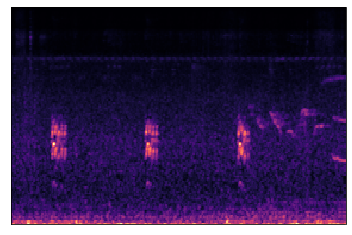

In [ ]:
lbd.specshow(x[0])

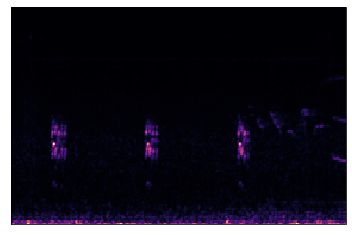

In [ ]:
lbd.specshow(x[0]**2)

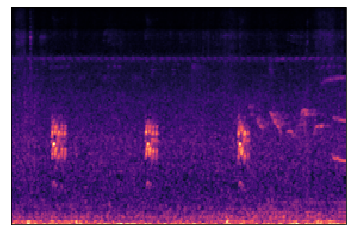

In [ ]:
lbd.specshow(x[0]**0.75)

In [ ]:
def SpecAugmentation(spec):
    """Applies spec augment striping to a sample
    Arguments:
        x {torch tensor} -- Input batch
    Returns:
        torch tensor - spec image augmented"""

    masking_time = T.TimeMasking(time_mask_param=64, iid_masks=True)
    spec = masking_time(spec)
    spec = masking_time(spec)

    masking_freq = T.FrequencyMasking(freq_mask_param=8, iid_masks=True)
    spec = masking_freq(spec) 
    spec = masking_freq(spec) 

    return spec

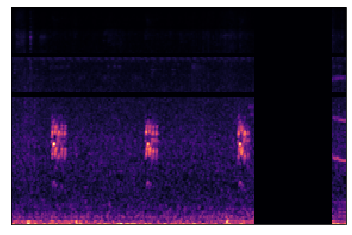

In [ ]:
spec_test = torch.from_numpy(x[0])
spec_aug = SpecAugmentation(spec_test)
spec_aug = spec_aug.numpy()
lbd.specshow(spec_aug)

In [ ]:
y[:5]

array([0.0025, 0.0025, 0.0025, 0.0025, 0.0025], dtype=float32)

# Training the model

In [ ]:
#Unused here, boilerplate fcn
def mixup_data(x, y, alpha=0.4):
    """Applies mixup to a sample
    Arguments:
        x {torch tensor} -- Input batch
        y {torch tensor} -- Labels
    Keyword Arguments:
        alpha {float} -- Parameter of the beta distribution (default: {0.4})
    Returns:
        torch tensor  -- Mixed input
        torch tensor  -- Labels of the original batch
        torch tensor  -- Labels of the shuffle batch
        float  -- Probability samples by the beta distribution"""
    lam = np.random.beta(alpha, alpha) if alpha > 0 else 1

    index = torch.randperm(x.size()[0]).cuda()

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]

    return mixed_x, y_a, y_b, lam

In [ ]:
def one_step(xb, yb, net, criterion, optimizer, scheduler=None):
  
  xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        
  optimizer.zero_grad()

  if np.random.rand() < PARAMS['specaugment_prob']:
    xb = SpecAugmentation(xb)
    
  if np.random.rand() < PARAMS['mixup_prob']:
    xb, y_a, y_b, _ = mixup_data(xb.cuda(), yb.cuda(), PARAMS['mixup_alpha'])
    yb = torch.clamp(y_a + y_b, 0, 1)
    
  o = net(xb)
  loss = criterion(o, yb)
  loss.backward()
  optimizer.step()

  neptune.log_metric('Training-loss', loss)
  
  with torch.no_grad():
      l = loss.item()
      o = o.sigmoid()
      yb = (yb > 0.5 )*1.0
      lrap = label_ranking_average_precision_score(yb.cpu().numpy(), o.cpu().numpy())
      o = (o > 0.5)*1.0
      prec = (o*yb).sum()/(1e-6 + o.sum())
      rec = (o*yb).sum()/(1e-6 + yb.sum())
      f1 = 2*prec*rec/(1e-6+prec+rec)

  if  scheduler is not None:
    scheduler.step()

  return l, lrap, f1.item(), rec.item(), prec.item()

In [ ]:
@torch.no_grad()
def evaluate(net, criterion, val_laoder):
    net.eval()

    os, y = [], []
    val_laoder = tqdm(val_laoder, leave = False, total=len(val_laoder))

    for icount, (xb, yb) in  enumerate(val_laoder):

        y.append(yb.to(DEVICE))

        xb = xb.to(DEVICE)
        o = net(xb)

        os.append(o)

    y = torch.cat(y)
    o = torch.cat(os)

    l = criterion(o, y).item()

    o = o.sigmoid()
    y = (y > 0.5)*1.0

    lrap = label_ranking_average_precision_score(y.cpu().numpy(), o.cpu().numpy())

    o = (o > 0.5)*1.0

    prec = ((o*y).sum()/(1e-6 + o.sum())).item()
    rec = ((o*y).sum()/(1e-6 + y.sum())).item()
    f1 = 2*prec*rec/(1e-6+prec+rec)

    return l, lrap, f1, rec, prec, 
    

In [ ]:
def one_epoch(net, criterion, optimizer, scheduler, train_laoder, val_laoder):
  net.train()
  l, lrap, prec, rec, f1, icount = 0.,0.,0.,0., 0., 0
  train_laoder = tqdm(train_laoder, leave = False)
  epoch_bar = train_laoder
  
  for (xb, yb) in  epoch_bar:
      # epoch_bar.set_description("----|----|----|----|---->")
      _l, _lrap, _f1, _rec, _prec = one_step(xb, yb, net, criterion, optimizer)
      l += _l
      lrap += _lrap
      f1 += _f1
      rec += _rec
      prec += _prec

      icount += 1
        
      if hasattr(epoch_bar, "set_postfix") and not icount%10:
          epoch_bar.set_postfix(
            loss="{:.6f}".format(l/icount),
            lrap="{:.3f}".format(lrap/icount),
            prec="{:.3f}".format(prec/icount),
            rec="{:.3f}".format(rec/icount),
            f1="{:.3f}".format(f1/icount),
          )
  
  scheduler.step()

  l /= icount
  lrap /= icount
  f1 /= icount
  rec /= icount
  prec /= icount
  
  l_val, lrap_val, f1_val, rec_val, prec_val = evaluate(net, criterion, val_laoder)
  
  return (l, l_val), (lrap, lrap_val), (f1, f1_val), (rec, rec_val), (prec, prec_val)

In [ ]:
class AutoSave:
  def __init__(self, top_k=2, metric="f1", mode="min", root=None, name="ckpt"):
    self.top_k = top_k
    self.logs = []
    self.metric = metric
    self.mode = mode
    self.root = Path(root or MODEL_ROOT)
    assert self.root.exists()
    self.name = name

    self.top_models = []
    self.top_metrics = []

  def log(self, model, metrics):
    metric = metrics[self.metric]
    rank = self.rank(metric)

    self.top_metrics.insert(rank+1, metric)
    if len(self.top_metrics) > self.top_k:
      self.top_metrics.pop(0)

    self.logs.append(metrics)
    self.save(model, metric, rank, metrics["epoch"])


  def save(self, model, metric, rank, epoch):
    t = time.strftime("%Y%m%d%H%M%S")
    name = "{}_epoch_{:02d}_{}_{:.04f}_{}".format(self.name, epoch, self.metric, metric, t)
    name = re.sub(r"[^\w_-]", "", name) + ".pth"
    path = self.root.joinpath(name)

    old_model = None
    self.top_models.insert(rank+1, name)
    if len(self.top_models) > self.top_k:
      old_model = self.root.joinpath(self.top_models[0])
      self.top_models.pop(0)      

    torch.save(model.state_dict(), path.as_posix())
    torch.save(model.state_dict(), 'model_dict.ckpt')
    neptune.log_artifact('model_dict.ckpt')

    if old_model is not None:
      old_model.unlink()

    self.to_json()

  def rank(self, val):
    r = -1
    for top_val in self.top_metrics:
      if val <= top_val:
        return r
      r += 1

    return r
  
  def to_json(self):
    # t = time.strftime("%Y%m%d%H%M%S")
    name = "{}_logs".format(self.name)
    name = re.sub(r"[^\w_-]", "", name) + ".json"
    path = self.root.joinpath(name)

    with path.open("w") as f:
      json.dump(self.logs, f, indent=2)


In [ ]:
def one_fold(model_name, fold, train_set, val_set, epochs=20, save=True, save_root=None):

  save_root = Path(save_root) or MODEL_ROOT

  saver = AutoSave(root=save_root, name=f"birdclef_{model_name}_fold{fold}", metric="f1_val")

  net = get_model(model_name).to(DEVICE)

  criterion = nn.BCEWithLogitsLoss()

  optimizer = optim.Adam(net.parameters(), lr=PARAMS['lr'])
  scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, eta_min=PARAMS['lr_anneal'], T_max=epochs)

  train_data = BirdClefDataset(audio_image_store, meta=df.iloc[train_set].reset_index(drop=True),
                           sr=SR, duration=PARAMS['DURATION'], is_train=True)
  train_laoder = DataLoader(train_data, batch_size=PARAMS['TRAIN_BATCH_SIZE'], num_workers=PARAMS['TRAIN_NUM_WORKERS'], shuffle=True, pin_memory=True, drop_last=True)

  #print(val_set)
  val_data = BirdClefDataset(audio_image_store, meta=df.iloc[val_set].reset_index(drop=True),  sr=SR, duration=PARAMS['DURATION'], is_train=False)
  val_laoder = DataLoader(val_data, batch_size=PARAMS['VAL_BATCH_SIZE'], num_workers=PARAMS['VAL_NUM_WORKERS'], shuffle=False, drop_last=True)

  epochs_bar = tqdm(list(range(epochs)), leave=False)
  for epoch in epochs_bar:
    epochs_bar.set_description(f"--> [EPOCH {epoch:02d}]")
    net.train()

    (l, l_val), (lrap, lrap_val), (f1, f1_val), (rec, rec_val), (prec, prec_val) = one_epoch(
        net=net,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        train_laoder=train_laoder,
        val_laoder=val_laoder,
      )

    epochs_bar.set_postfix(
    loss="({:.6f}, {:.6f})".format(l, l_val),
    prec="({:.3f}, {:.3f})".format(prec, prec_val),
    rec="({:.3f}, {:.3f})".format(rec, rec_val),
    f1="({:.3f}, {:.3f})".format(f1, f1_val),
    lrap="({:.3f}, {:.3f})".format(lrap, lrap_val),
    )

    print(
        "[{epoch:02d}] loss: {loss} lrap: {lrap} f1: {f1} rec: {rec} prec: {prec}".format(
            epoch=epoch,
            loss="({:.6f}, {:.6f})".format(l, l_val),
            prec="({:.3f}, {:.3f})".format(prec, prec_val),
            rec="({:.3f}, {:.3f})".format(rec, rec_val),
            f1="({:.3f}, {:.3f})".format(f1, f1_val),
            lrap="({:.3f}, {:.3f})".format(lrap, lrap_val),
        )
    )

    if save:
      metrics = {
          "loss": l, "lrap": lrap, "f1": f1, "rec": rec, "prec": prec,
          "loss_val": l_val, "lrap_val": lrap_val, "f1_val": f1_val, "rec_val": rec_val, "prec_val": prec_val,
          "epoch": epoch,
      }

      neptune.log_metric('Training-loss', metrics["loss"])
      neptune.log_metric('Validation-loss', metrics["loss_val"])
      neptune.log_metric('Validation-F1', metrics["f1_val"])
      neptune.log_metric('Training-F1', metrics["f1"])
      neptune.log_metric('Validation-lrap', metrics["lrap_val"])
      neptune.log_metric('Training-lrap', metrics["lrap"])

      saver.log(net, metrics)

  return net, optimizer, criterion, train_laoder

In [ ]:
def train(model_name, epochs=20, save=True, n_splits=5, seed=177, save_root=None, suffix="", folds=None):
  gc.collect()
  torch.cuda.empty_cache()

  save_root = save_root or MODEL_ROOT/f"{model_name}{suffix}"
  save_root.mkdir(exist_ok=True, parents=True)
  
  fold_bar = tqdm(df.reset_index().groupby("fold").index.apply(list).items(), total=df.fold.max())

  # Print fold, val_set to confirm for the first fold the 1 group is the val_set
  
  for fold, val_set in fold_bar:
      if folds and not fold in folds:
        continue
      
      print(f"\n############################### [FOLD {fold}]")
      fold_bar.set_description(f"[FOLD {fold}]")
      train_set = np.setdiff1d(df.index, val_set)
        
      net, optimizer, criterion, train_laoder = one_fold(model_name, fold=fold, train_set=train_set , val_set=val_set , epochs=epochs, save=save, save_root=save_root)
    
      gc.collect()
      torch.cuda.empty_cache()
      return net, optimizer, criterion, train_laoder

In [ ]:
MODEL_NAMES = [
      PARAMS['model_name']
] 
MODEL_NAMES

['resnest50']

In [ ]:
neptune.create_experiment('colab-pass',params=PARAMS,tags=['BirdCLEF21', "Colab", "Convnets"])

https://app.neptune.ai/dryanfurman/BirdCLEF21/e/BIRD-171


Experiment(BIRD-171)

In [ ]:
%%time
for model_name in MODEL_NAMES:
  print("\n\n###########################################", model_name.upper())
  try:
    net, optimizer, criterion, train_laoder = train(model_name, epochs=PARAMS['epochs'], suffix=f"_sr{SR}_d{PARAMS['DURATION']}_v1_v1", folds=PARAMS['folds'])
  except Exception as e:
    raise ValueError() from  e



########################################### RESNEST50



############################### [FOLD 1]


[00] loss: (0.037180, 0.031703) lrap: (0.212, 0.396) f1: (0.047, 0.147) rec: (0.027, 0.081) prec: (0.439, 0.732)


[01] loss: (0.029630, 0.029393) lrap: (0.546, 0.566) f1: (0.334, 0.397) rec: (0.216, 0.266) prec: (0.789, 0.776)


[02] loss: (0.027725, 0.028531) lrap: (0.668, 0.617) f1: (0.515, 0.468) rec: (0.379, 0.329) prec: (0.812, 0.809)


[03] loss: (0.026609, 0.027801) lrap: (0.728, 0.656) f1: (0.607, 0.548) rec: (0.482, 0.417) prec: (0.824, 0.798)


[04] loss: (0.025792, 0.027349) lrap: (0.769, 0.689) f1: (0.666, 0.583) rec: (0.557, 0.456) prec: (0.833, 0.807)


[05] loss: (0.025039, 0.027013) lrap: (0.806, 0.707) f1: (0.716, 0.609) rec: (0.622, 0.482) prec: (0.845, 0.828)


[06] loss: (0.024405, 0.026490) lrap: (0.832, 0.733) f1: (0.756, 0.652) rec: (0.681, 0.540) prec: (0.853, 0.823)


[07] loss: (0.023831, 0.026354) lrap: (0.857, 0.738) f1: (0.788, 0.668) rec: (0.728, 0.564) prec: (0.861, 0.819)


[08] loss: (0.023240, 0.026005) lrap: (0.881, 0.754) f1: (0.818, 0.691) rec: (0.775, 0.599) prec: (0.867, 0.818)


[09] loss: (0.022771, 0.025942) lrap: (0.899, 0.758) f1: (0.840, 0.699) rec: (0.812, 0.612) prec: (0.872, 0.814)


[10] loss: (0.022373, 0.025810) lrap: (0.913, 0.766) f1: (0.855, 0.709) rec: (0.839, 0.623) prec: (0.873, 0.821)


[11] loss: (0.022132, 0.025784) lrap: (0.922, 0.768) f1: (0.863, 0.711) rec: (0.853, 0.629) prec: (0.873, 0.818)
CPU times: user 43min, sys: 30min 44s, total: 1h 13min 45s
Wall time: 1h 17min 36s


In [ ]:
PARAMS

{'DURATION': 7,
 'MAX_READ_SAMPLES': 10,
 'TRAIN_BATCH_SIZE': 100,
 'TRAIN_NUM_WORKERS': 2,
 'VAL_BATCH_SIZE': 128,
 'VAL_NUM_WORKERS': 2,
 'epochs': 12,
 'fold_fpath': '/content/drive/MyDrive/Colab Files/data/birds/gpds_for_blockCV/new_folder_blockcv_equalsplits.csv',
 'fold_type': 'geotemporal-4fold-56grids',
 'folds': [3],
 'lr': 0.0008,
 'lr_anneal': 1e-05,
 'mixup': 'disabled',
 'mixup_alpha': 0.5,
 'mixup_prob': 0,
 'model_name': 'resnest50',
 'multi_label': 'enabled',
 'secondary_label_activations': 0.5,
 'specaugment_prob': 0,
 'specstriping_aug': 'disabled'}